In [1]:
import numpy as np
import matplotlib.pyplot as plt
from Fourierbasis import generate_fourier_basis_function

def logistic(z):
    return 1 / (1 + np.exp(-z))

In [30]:
num_terms = 100
coefficients = np.array([1 if i<=20 else 1/(i-20)**3 for i in range(1,num_terms+1)]).reshape(num_terms,1)
f = generate_fourier_basis_function(coefficients)
# Generate synthetic data
# g^-1 = A'

n = 100_000
alpha = 2
period = 2 * np.pi
np.random.seed(42)
X = 10000 * (np.random.rand(n, 1)- 0.5)
y = (logistic(f(X)) +  np.random.randn(n, 1)/50 > 0.5).astype(int)

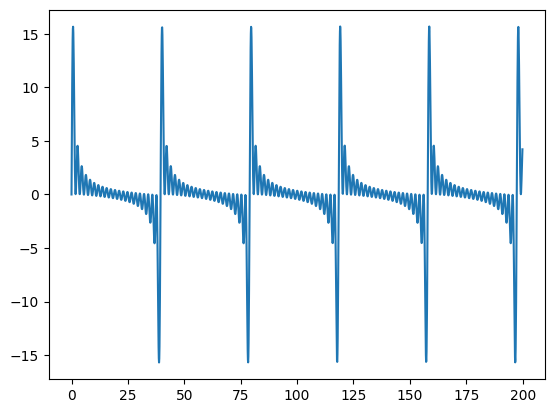

In [31]:
xx = np.arange(0,200,0.1)
xx = xx.reshape(xx.shape[0],1)
plt.plot(xx,f(xx) )



In [ ]:
def prior_log_density(theta, gradient = False):
    p = len(theta)
    k = np.arange(1,p+1).reshape(p,1)
    if gradient:
        # px1 array
        return - n**(1/(2*alpha + 1))* (k**(2*alpha) * theta)
    return -0.5 * n**(1/(2*alpha + 1)) * np.dot(k**(2*alpha).T,(theta**2))

def log_likelihood(theta, X, y, gradient = False):
    ff = generate_fourier_basis_function(theta)
    if gradient:
        p = len(theta)
        k = np.arange(1,p+1).reshape(1,p)/period
        # px1 array
        return np.dot((y - logistic(ff(X))).T, np.sin(np.dot(X,k))).T
        
    log_like = np.dot(y.T, ff(X)) - np.log(1 + np.exp(ff(X))).sum()
    return log_like

# Gradient of log-likelihood function
def grad_log_likelihood(theta, X, y):
    grad_prior = prior_log_density(theta, True)
    grad_like = log_likelihood(theta, X, y, True)
    
    return grad_like + grad_prior

# Unadjusted Langevin algorithm
def langevin_algorithm(num_samples, step_size, initial_theta, X, y):
    theta_current = initial_theta
    samples = [theta_current]
    p = len(initial_theta)
    for i in range(num_samples):
        # Compute the gradient of the log-likelihood
        grad_ll = grad_log_likelihood(theta_current, X, y)

        # Update theta using Langevin dynamics
        theta_proposed = theta_current + step_size * grad_ll + np.sqrt(2 * step_size) * np.random.randn(p, 1)

        # Accept the proposal
        theta_current = theta_proposed
        samples.append(theta_current)

    return np.array(samples)
